References:

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
2. https://pywavelets.readthedocs.io/en/latest/

In [1]:
import os
import sys
import torch
import argparse
import torchvision
import numpy as np
import torch.nn as nn
import scipy.io as sio
import cv2
import pywt
import pywt.data
import matplotlib.image as image

from PIL import Image
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from os.path import join, isdir, abspath, dirname
import matplotlib.pyplot as plt
# Customized import.
from networks import HED
from datasets import BsdsDataset
from utils import Logger, AverageMeter, \
    load_checkpoint, save_checkpoint, load_vgg16_caffe, load_pretrained_caffe


# # Parse arguments.
# parser = argparse.ArgumentParser(description='HED training.')
# # 1. Actions.
# parser.add_argument('--test',             default=False,             help='Only test the model.', action='store_true')
# # 2. Counts.
# parser.add_argument('--train_batch_size', default=1,    type=int,   metavar='N', help='Training batch size.')
# parser.add_argument('--test_batch_size',  default=1,    type=int,   metavar='N', help='Test batch size.')
# parser.add_argument('--train_iter_size',  default=10,   type=int,   metavar='N', help='Training iteration size.')
# parser.add_argument('--max_epoch',        default=40,   type=int,   metavar='N', help='Total epochs.')
# parser.add_argument('--print_freq',       default=500,  type=int,   metavar='N', help='Print frequency.')
# # 3. Optimizer settings.
# parser.add_argument('--lr',               default=1e-6, type=float, metavar='F', help='Initial learning rate.')
# parser.add_argument('--lr_stepsize',      default=1e4,  type=int,   metavar='N', help='Learning rate step size.')
# # Note: Step size is based on number of iterations, not number of batches.
# #   https://github.com/s9xie/hed/blob/94fb22f10cbfec8d84fbc0642b224022014b6bd6/src/caffe/solver.cpp#L498
# parser.add_argument('--lr_gamma',         default=0.1,  type=float, metavar='F', help='Learning rate decay (gamma).')
# parser.add_argument('--momentum',         default=0.9,  type=float, metavar='F', help='Momentum.')
# parser.add_argument('--weight_decay',     default=2e-4, type=float, metavar='F', help='Weight decay.')
# # 4. Files and folders.
# parser.add_argument('--vgg16_caffe',      default='',                help='Resume VGG-16 Caffe parameters.')
# parser.add_argument('--checkpoint',       default='',                help='Resume the checkpoint.')
# parser.add_argument('--caffe_model',      default='',                help='Resume HED Caffe model.')
# parser.add_argument('--output',           default='./output',        help='Output folder.')
# parser.add_argument('--dataset',          default='./data/HED-BSDS', help='HED-BSDS dataset folder.')
# # 5. Others.
# parser.add_argument('--cpu',              default=False,             help='Enable CPU mode.', action='store_true')
# args = parser.parse_args()

# Set device.
device = torch.device('cuda')


In [2]:
def wav_trans_grayscale(images):
    images = torchvision.utils.make_grid(images)
    npimg = images.numpy()
    img_np_right_dim = np.transpose(npimg, (1, 2, 0))
    img_np_right_dim = cv2.cvtColor(img_np_right_dim, cv2.COLOR_BGR2GRAY)
    coeffs2 = pywt.dwt2(img_np_right_dim, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return([LL, LH, HL, HH])

def WT_grayscale_path_input(path):  
    """Takes as input path string"""
    orig_image = plt.imread(path)
    if(len(orig_image.shape)==3):
        gray_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = orig_image
    coeffs2 = pywt.dwt2(gray_image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return [LL, LH, HL, HH]

def im_save_path_modifier(input_path, mode):
    """
    parameter: input_path is the path of the original image
    parameter: mode is one of LL, LH, HL, HH
    """
    dir_path = input_path[:16] + f'{mode}/' + input_path[16:input_path.rfind('/')]
    image_path = input_path[:16] + f'{mode}/' + input_path[16:]
    return(dir_path, image_path)

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
################################################
# II. Datasets.
################################################
# Datasets and dataloaders.

train_dataset_LL = BsdsDataset(dataset_dir='./data/HED-BSDS/LL', split='train')

train_dataset_LH = BsdsDataset(dataset_dir='./data/HED-BSDS/LH', split='train')

train_dataset_HL = BsdsDataset(dataset_dir='./data/HED-BSDS/HL', split='train')

train_dataset_HH = BsdsDataset(dataset_dir='./data/HED-BSDS/HH', split='train')

train_loader_LL  = DataLoader(train_dataset_LL, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)

train_loader_LH  = DataLoader(train_dataset_LH, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)

train_loader_HL  = DataLoader(train_dataset_HL, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)

train_loader_HH  = DataLoader(train_dataset_HH, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)


# test_dataset  = BsdsDataset(dataset_dir='./data/HED-BSDS', split='test')

# test_loader   = DataLoader(test_dataset,  batch_size=1,
#                            num_workers=4, drop_last=False, shuffle=False)



In [4]:
dataiter_LL = iter(train_loader_LL)
dataiter_LH = iter(train_loader_LH)
dataiter_HL = iter(train_loader_HL)
dataiter_HH = iter(train_loader_HH)

In [5]:
# step 1: import 4 images from 4 dataloaders.

images_LL, labels1 = dataiter_LL.next()
images_LH, labels2 = dataiter_LH.next()
images_HL, labels3 = dataiter_HL.next()
images_HH, labels4 = dataiter_HH.next()


In [6]:
# verify that the images are the same
torch.equal(labels3, labels4)

True

In [7]:
net = nn.DataParallel(HED(device))
net.to(device);

# Initialize the weights for HED model.
def weights_init(m):
    """ Weight initialization function. """
    if isinstance(m, nn.Conv2d):
        # Initialize: m.weight.
        if m.weight.data.shape == torch.Size([1, 5, 1, 1]):
            # Constant initialization for fusion layer in HED network.
            torch.nn.init.constant_(m.weight, 0.2)
        else:
            # Zero initialization following official repository.
            # Reference: hed/docs/tutorial/layers.md
            m.weight.data.zero_()
        # Initialize: m.bias.
        if m.bias is not None:
            # Zero initialization.
            m.bias.data.zero_()
            

net.apply(weights_init);
net_parameters_id = defaultdict(list)
# Optimizer settings.
net_parameters_id = defaultdict(list)
for name, param in net.named_parameters():
    if name in ['module.conv1_1.weight', 'module.conv1_2.weight',
                'module.conv2_1.weight', 'module.conv2_2.weight',
                'module.conv3_1.weight', 'module.conv3_2.weight', 'module.conv3_3.weight',
                'module.conv4_1.weight', 'module.conv4_2.weight', 'module.conv4_3.weight']:
        print('{:26} lr:    1 decay:1'.format(name)); net_parameters_id['conv1-4.weight'].append(param)
    elif name in ['module.conv1_1.bias', 'module.conv1_2.bias',
                  'module.conv2_1.bias', 'module.conv2_2.bias',
                  'module.conv3_1.bias', 'module.conv3_2.bias', 'module.conv3_3.bias',
                  'module.conv4_1.bias', 'module.conv4_2.bias', 'module.conv4_3.bias']:
        print('{:26} lr:    2 decay:0'.format(name)); net_parameters_id['conv1-4.bias'].append(param)
    elif name in ['module.conv5_1.weight', 'module.conv5_2.weight', 'module.conv5_3.weight']:
        print('{:26} lr:  100 decay:1'.format(name)); net_parameters_id['conv5.weight'].append(param)
    elif name in ['module.conv5_1.bias', 'module.conv5_2.bias', 'module.conv5_3.bias'] :
        print('{:26} lr:  200 decay:0'.format(name)); net_parameters_id['conv5.bias'].append(param)
    elif name in ['module.score_dsn1.weight', 'module.score_dsn2.weight',
                  'module.score_dsn3.weight', 'module.score_dsn4.weight', 'module.score_dsn5.weight']:
        print('{:26} lr: 0.01 decay:1'.format(name)); net_parameters_id['score_dsn_1-5.weight'].append(param)
    elif name in ['module.score_dsn1.bias', 'module.score_dsn2.bias',
                  'module.score_dsn3.bias', 'module.score_dsn4.bias', 'module.score_dsn5.bias']:
        print('{:26} lr: 0.02 decay:0'.format(name)); net_parameters_id['score_dsn_1-5.bias'].append(param)
    elif name in ['module.score_final.weight']:
        print('{:26} lr:0.001 decay:1'.format(name)); net_parameters_id['score_final.weight'].append(param)
    elif name in ['module.score_final.bias']:
        print('{:26} lr:0.002 decay:0'.format(name)); net_parameters_id['score_final.bias'].append(param)

lr = 1e-6
momentum = 0.9
weight_decay = 2e-4
lr_stepsize = 1e4
lr_gamma = 0.1


# Create optimizer.
opt = torch.optim.SGD([
    {'params': net_parameters_id['conv1-4.weight']      , 'lr': lr*1    , 'weight_decay': weight_decay},
    {'params': net_parameters_id['conv1-4.bias']        , 'lr': lr*2    , 'weight_decay': 0.},
    {'params': net_parameters_id['conv5.weight']        , 'lr': lr*100  , 'weight_decay': weight_decay},
    {'params': net_parameters_id['conv5.bias']          , 'lr': lr*200  , 'weight_decay': 0.},
    {'params': net_parameters_id['score_dsn_1-5.weight'], 'lr': lr*0.01 , 'weight_decay': weight_decay},
    {'params': net_parameters_id['score_dsn_1-5.bias']  , 'lr': lr*0.02 , 'weight_decay': 0.},
    {'params': net_parameters_id['score_final.weight']  , 'lr': lr*0.001, 'weight_decay': weight_decay},
    {'params': net_parameters_id['score_final.bias']    , 'lr': lr*0.002, 'weight_decay': 0.},
], lr=lr, momentum=momentum, weight_decay=weight_decay)
# Note: In train_val.prototxt and deploy.prototxt, the learning rates of score_final.weight/bias are different.

# Learning rate scheduler.
lr_schd = lr_scheduler.StepLR(opt, step_size=lr_stepsize, gamma=lr_gamma)


################################################
# IV. Pre-trained parameters.
################################################
# Load parameters from pre-trained VGG-16 Caffe model.
load_vgg16_caffe(net, './data/5stage-vgg.py36pickle');

# # Resume the checkpoint.
# if args.checkpoint:
#     load_checkpoint(net, opt, args.checkpoint)  # Omit the returned values.

# # Resume the HED Caffe model.
# if args.caffe_model:
#     load_pretrained_caffe(net, args.caffe_model)





module.conv1_1.weight      lr:    1 decay:1
module.conv1_1.bias        lr:    2 decay:0
module.conv1_2.weight      lr:    1 decay:1
module.conv1_2.bias        lr:    2 decay:0
module.conv2_1.weight      lr:    1 decay:1
module.conv2_1.bias        lr:    2 decay:0
module.conv2_2.weight      lr:    1 decay:1
module.conv2_2.bias        lr:    2 decay:0
module.conv3_1.weight      lr:    1 decay:1
module.conv3_1.bias        lr:    2 decay:0
module.conv3_2.weight      lr:    1 decay:1
module.conv3_2.bias        lr:    2 decay:0
module.conv3_3.weight      lr:    1 decay:1
module.conv3_3.bias        lr:    2 decay:0
module.conv4_1.weight      lr:    1 decay:1
module.conv4_1.bias        lr:    2 decay:0
module.conv4_2.weight      lr:    1 decay:1
module.conv4_2.bias        lr:    2 decay:0
module.conv4_3.weight      lr:    1 decay:1
module.conv4_3.bias        lr:    2 decay:0
module.conv5_1.weight      lr:  100 decay:1
module.conv5_1.bias        lr:  200 decay:0
module.conv5_2.weight      lr:  

In [8]:
net

DataParallel(
  (module): HED(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(35, 35))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(

In [9]:
net0 = net
net1 = net
net2 = net
net3 = net

In [10]:
opt0 = opt
opt1 = opt
opt2 = opt
opt3 = opt

In [12]:
net0.train()
net1.train()
net2.train()
net3.train()

opt0.zero_grad()
opt1.zero_grad()
opt2.zero_grad()
opt3.zero_grad()


batch_loss_meter = AverageMeter()
lr_schd.step()
images_LL, labels1 = images_LL.to(device), labels1.to(device)
images_LH, labels2 = images_LH.to(device), labels2.to(device)
images_HL, labels3 = images_HL.to(device), labels3.to(device)
images_HH, labels4 = images_HH.to(device), labels4.to(device)


In [14]:
preds_list_LL = net(images_LL)
preds_list_LH = net(images_LH)
preds_list_HL = net(images_HL)
preds_list_HH = net(images_HH)

#### We must plot the predictions just to see what the network got lol.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


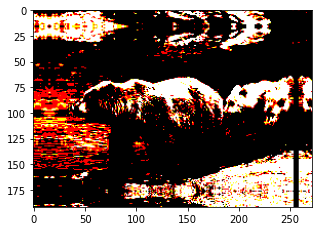

In [49]:

fig = plt.figure(figsize = [5,5])
ax0 = fig.add_subplot(111)
ax0.imshow(np.transpose(images_LL.squeeze().cpu().numpy(), (1,2,0)))


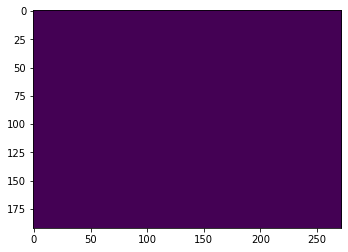

In [53]:
logic = net(images_LL)
logic0 = logic[0]
plt.imshow(logic[0].squeeze().cpu().detach().numpy())

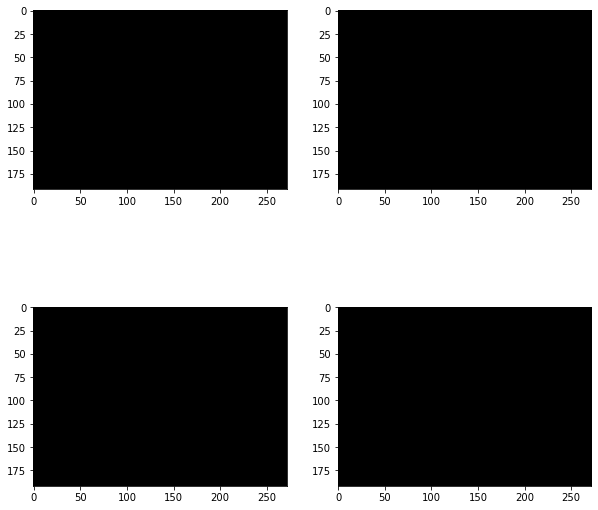

In [46]:
i = 4

fig = plt.figure(figsize = [10,10])
ax0 = fig.add_subplot(221)
ax0.imshow(preds_list_LL[i].squeeze().cpu().detach().numpy(), cmap = 'gray')
ax1 = fig.add_subplot(222)
ax1.imshow(preds_list_LH[i].squeeze().cpu().detach().numpy(), cmap = 'gray')
ax2 = fig.add_subplot(223)
ax2.imshow(preds_list_HL[i].squeeze().cpu().detach().numpy(), cmap = 'gray')
ax3 = fig.add_subplot(224)
ax3.imshow(preds_list_HH[i].squeeze().cpu().detach().numpy(), cmap = 'gray')

#### Taking inverse discrete wavelet transform

In [59]:
preds_list = []
for i in range(6):
    LL = preds_list_LL[i].cpu().detach().numpy().reshape(preds_list_LL[i].shape[2], preds_list_LL[i].shape[3])
    LH = preds_list_LH[i].cpu().detach().numpy().reshape(preds_list_LL[i].shape[2], preds_list_LL[i].shape[3])
    HL = preds_list_HL[i].cpu().detach().numpy().reshape(preds_list_LL[i].shape[2], preds_list_LL[i].shape[3])
    HH = preds_list_HH[i].cpu().detach().numpy().reshape(preds_list_LL[i].shape[2], preds_list_LL[i].shape[3])
    full_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    full_image = torch.reshape(torch.from_numpy(full_image), (1,1,preds_list_LL[i].shape[2]*2, preds_list_LL[i].shape[3]*2))
    full_image = full_image.to(device)
    preds_list.append(full_image)

#### Plotting the inverse wavelet transform

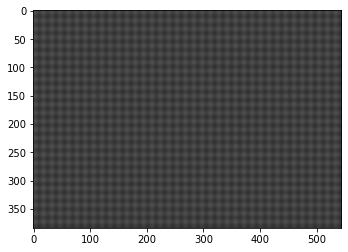

In [57]:
plt.imshow(preds_list[0].squeeze().cpu().detach().numpy(), cmap = 'gray')

In [33]:
preds_list_HH[0].shape

torch.Size([1, 1, 192, 272])

In [13]:
preds_list = []
for i in range(6):
    LL = preds_list_LL[i].cpu().detach().numpy().reshape(192, 272)
    LH = preds_list_LH[i].cpu().detach().numpy().reshape(192, 272)
    HL = preds_list_HL[i].cpu().detach().numpy().reshape(192, 272)
    HH = preds_list_HH[i].cpu().detach().numpy().reshape(192, 272)
    full_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    full_image = torch.reshape(torch.from_numpy(full_image), (1,1,384, 544))
    full_image = full_image.to(device)
    preds_list.append(full_image)

In [14]:
preds_list[0].shape

torch.Size([1, 1, 384, 544])

In [16]:
# calculate loss

def weighted_cross_entropy_loss(preds, edges):
    """ Calculate sum of weighted cross entropy loss. """
    # Reference:
    #   hed/src/caffe/layers/sigmoid_cross_entropy_loss_layer.cpp
    #   https://github.com/s9xie/hed/issues/7
    mask = (edges > 0.5).float()
    b, c, h, w = mask.shape
    num_pos = torch.sum(mask, dim=[1, 2, 3]).float()  # Shape: [b,].
    num_neg = c * h * w - num_pos                     # Shape: [b,].
    weight = torch.zeros_like(mask)
    weight[edges > 0.5]  = num_neg / (num_pos + num_neg)
    weight[edges <= 0.5] = num_pos / (num_pos + num_neg)
    # Calculate loss.
    losses = torch.nn.functional.binary_cross_entropy(preds.float(), edges.float(), weight=weight, reduction='none')
    loss   = torch.sum(losses) / b
    return loss

In [21]:
batch_loss = sum([weighted_cross_entropy_loss(preds, labels1) for preds in preds_list])

In [24]:
batch_loss.requires_grad = True

In [51]:
# full_image.shape # assume this is the correct shape

(384, 544)

In [18]:
def train(train_loader_LL, train_loader_LH, train_loader_HL, train_loader_HH, net_LL, net_LH, net_HL, net_HH, opt_LL, opt_LH, opt_HL, opt_HH, lr_schd, epoch, save_dir_LL, save_dir_LH, save_dir_HL, save_dir_HH):
    """ Training procedure. """

    dataiter_LL = iter(train_loader_LL)
    dataiter_LH = iter(train_loader_LH)
    dataiter_HL = iter(train_loader_HL)
    dataiter_HH = iter(train_loader_HH)
    
    # Create the directory.
    if not isdir(save_dir_LL):
        os.makedirs(save_dir_LL)
    # Create the directory.
    if not isdir(save_dir_LH):
        os.makedirs(save_dir_LH)
    # Create the directory.
    if not isdir(save_dir_HL):
        os.makedirs(save_dir_HL)
    # Create the directory.
    if not isdir(save_dir_HH):
        os.makedirs(save_dir_HH)
        
        
    # Switch to train mode and clear the gradient.
    net_LL.train()
    opt_LL.zero_grad()
    
    net_LH.train()
    opt_LH.zero_grad()
    
    net_HL.train()
    opt_HL.zero_grad()
    
    net_HH.train()
    opt_HH.zero_grad()
    
    
    # Initialize meter and list.
    batch_loss_meter = AverageMeter()
    # Note: The counter is used here to record number of batches in current training iteration has been processed.
    #       It aims to have large training iteration number even if GPU memory is not enough. However, such trick
    #       can be used because batch normalization is not used in the network architecture.
    
    
    counter = 0
    
    for i in range(tqdm(train_dataset.__len__())):
        batch_index, (images_LL, edges) = dataiter_LL.next()
        batch_index, (images_LH, edges) = dataiter_LH.next()
        batch_index, (images_HL, edges) = dataiter_HL.next()
        batch_index, (images_HH, edges) = dataiter_HH.next()
        # Adjust learning rate and modify counter following Caffe's way.
        if counter == 0:
            lr_schd.step()  # Step at the beginning of the iteration.
        counter += 1
        # Get images and edges from current batch.
        
        images_LL, edges = images_LL.to(device), edges.to(device)
        images_LH, edges = images_LH.to(device), edges.to(device)
        images_HL, edges = images_HL.to(device), edges.to(device)
        images_HH, edges = images_HH.to(device), edges.to(device)


        # Generate predictions.
        preds_list_LL = net_LL(images_LL)
        preds_list_LH = net_LH(images_LH)
        preds_list_HL = net_HL(images_HL)
        preds_list_HH = net_LL(images_HH)
        # Calculate the loss of current batch (sum of all scales and fused).
        # Note: Here we mimic the "iteration" in official repository: iter_size batches will be considered together
        #       to perform one gradient update. To achieve the goal, we calculate the equivalent iteration loss
        #       eqv_iter_loss of current batch and generate the gradient. Then, instead of updating the weights,
        #       we continue to calculate eqv_iter_loss and add the newly generated gradient to current gradient.
        #       After iter_size batches, we will update the weights using the accumulated gradients and then zero
        #       the gradients.
        # Reference:
        #   https://github.com/s9xie/hed/blob/94fb22f10cbfec8d84fbc0642b224022014b6bd6/src/caffe/solver.cpp#L230
        #   https://www.zhihu.com/question/37270367
        
        # major change here
        # use IDWT to generate image
        # call that preds and pass it to loss function
        
        preds_list = []
        for i in range(6):
            LL = preds_list_LL[i].cpu().detach().numpy().reshape(192, 272)
            LH = preds_list_LH[i].cpu().detach().numpy().reshape(192, 272)
            HL = preds_list_HL[i].cpu().detach().numpy().reshape(192, 272)
            HH = preds_list_HH[i].cpu().detach().numpy().reshape(192, 272)
            full_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
            full_image = torch.reshape(torch.from_numpy(full_image), (1,1,384, 544))
            full_image = full_image.to(device)
            preds_list.append(full_image)
        
        batch_loss = sum([weighted_cross_entropy_loss(preds, edges) for preds in preds_list])
        eqv_iter_loss = batch_loss / args.train_iter_size

                
        
        
        # Generate the gradient and accumulate (using equivalent average loss).
        eqv_iter_loss.backward()
        
        
        
        if counter == args.train_iter_size:
            opt_LL.step()
            opt_LH.step()
            opt_HL.step()
            opt_HH.step()
            opt_LL.zero_grad()
            opt_LH.zero_grad()
            opt_HL.zero_grad()
            opt_HH.zero_grad()
            counter = 0  # Reset the counter.
            
        # Record loss.
        batch_loss_meter.update(batch_loss.item())
        
        
        # Log and save intermediate images.
        if batch_index % args.print_freq == args.print_freq - 1:
            # Log.
            print(('Training epoch:{}/{}, batch:{}/{} current iteration:{}, ' +
                   'current batch batch_loss:{}, epoch average batch_loss:{}, learning rate list:{}.').format(
                   epoch, args.max_epoch, batch_index, len(train_loader_LL), lr_schd.last_epoch,
                   batch_loss_meter.val, batch_loss_meter.avg, lr_schd.get_lr()))
            # Generate intermediate images.
            preds_list_and_edges = preds_list + [edges]
            _, _, h, w = preds_list_and_edges[0].shape
            interm_images = torch.zeros((len(preds_list_and_edges), 1, h, w))
            for i in range(len(preds_list_and_edges)):
                # Only fetch the first image in the batch.
                interm_images[i, 0, :, :] = preds_list_and_edges[i][0, 0, :, :]
            # Save the images.
            torchvision.utils.save_image(interm_images, join(save_dir, 'batch-{}-1st-image.png'.format(batch_index)))
    # Return the epoch average batch_loss.
    return batch_loss_meter.avg


In [20]:
def test(test_loader_LL, test_loader_LH, test_loader_HL, test_loader_HH,  net_LL, net_LH, net_HL, net_HH, save_dir_LL, save_dir_LH, save_dir_HL, save_dir_HH):
    """ Test procedure. """
    


    dataiter_test_LL = iter(test_loader_LL)
    dataiter_test_LH = iter(test_loader_LH)
    dataiter_test_HL = iter(test_loader_HL)
    dataiter_test_HH = iter(test_loader_HH)


    # Create the directories.
    if not isdir(save_dir_LL):
        os.makedirs(save_dir_LL)
    if not isdir(save_dir_LH):
        os.makedirs(save_dir_LH)
    if not isdir(save_dir_HL):
        os.makedirs(save_dir_HL)
    if not isdir(save_dir_HH):
        os.makedirs(save_dir_HH)
        
    save_png_dir_LL = join(save_dir_LL, 'png')
    save_png_dir_LH = join(save_dir_LH, 'png')
    save_png_dir_HL = join(save_dir_HL, 'png')
    save_png_dir_HH = join(save_dir_HH, 'png')

    
    
    if not isdir(save_png_dir_LL):
        os.makedirs(save_png_dir_LL)
    if not isdir(save_png_dir_LH):
        os.makedirs(save_png_dir_LH)
    if not isdir(save_png_dir_HL):
        os.makedirs(save_png_dir_HL)
    if not isdir(save_png_dir_HH):
        os.makedirs(save_png_dir_HH)
        
    
    save_mat_dir_LL = join(save_dir_LL, 'mat')
    save_mat_dir_LH = join(save_dir_LH, 'mat')
    save_mat_dir_HL = join(save_dir_HL, 'mat')
    save_mat_dir_HH = join(save_dir_HH, 'mat')

    
    
    if not isdir(save_mat_dir_LL):
        os.makedirs(save_mat_dir_LL)
    if not isdir(save_mat_dir_LH):
        os.makedirs(save_mat_dir_LH)
    if not isdir(save_mat_dir_HL):
        os.makedirs(save_mat_dir_HL)
    if not isdir(save_mat_dir_HH):
        os.makedirs(save_mat_dir_HH)
        
        
    # Switch to evaluation mode.
    net_LL.eval()
    net_LH.eval()
    net_HL.eval()
    net_HH.eval()
    # Generate predictions and save.
    assert args.test_batch_size == 1  # Currently only support test batch size 1.
          

        
    for i in range(200): # hard-coding temporarily
        batch_index, images_LL = dataiter_test_LL.next()
        batch_index, images_LH = dataiter_test_LH.next()
        batch_index, images_HL = dataiter_test_HL.next()
        batch_index, images_HH = dataiter_test_HH.next()
        
        images_LL = images_LL.cuda()
        images_LH = images_LH.cuda()
        images_HL = images_HL.cuda()
        images_HH = images_HH.cuda()
        
        _, _, h, w = images_LL.shape
        
        preds_list_LL = net_LL(images_LL)
        preds_list_LH = net_LH(images_LH)
        preds_list_HL = net_HL(images_HL)
        preds_list_HH = net_HH(images_HH)
        
        preds_list = []
        for i in range(6):
            LL = preds_list_LL[i].cpu().detach().numpy().reshape(192, 272)
            LH = preds_list_LH[i].cpu().detach().numpy().reshape(192, 272)
            HL = preds_list_HL[i].cpu().detach().numpy().reshape(192, 272)
            HH = preds_list_HH[i].cpu().detach().numpy().reshape(192, 272)
            full_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
            full_image = torch.reshape(torch.from_numpy(full_image), (1,1,384, 544))
            full_image = full_image.to(device)
            preds_list.append(full_image)
        
        # generate preds_list (IDWT)
        
        fuse       = preds_list[-1].detach().cpu().numpy()[0, 0]  # Shape: [h, w].
        name       = test_loader_LL.dataset.images_name[batch_index]
        
        sio.savemat(join(save_mat_dir_LL, '{}.mat'.format(name)), {'result': fuse})
        sio.savemat(join(save_mat_dir_LH, '{}.mat'.format(name)), {'result': fuse})
        sio.savemat(join(save_mat_dir_HL, '{}.mat'.format(name)), {'result': fuse})
        sio.savemat(join(save_mat_dir_HH, '{}.mat'.format(name)), {'result': fuse})

        Image.fromarray((fuse * 255).astype(np.uint8)).save(join(save_png_dir_LL, '{}.png'.format(name)))
        Image.fromarray((fuse * 255).astype(np.uint8)).save(join(save_png_dir_LH, '{}.png'.format(name)))
        Image.fromarray((fuse * 255).astype(np.uint8)).save(join(save_png_dir_HL, '{}.png'.format(name)))
        Image.fromarray((fuse * 255).astype(np.uint8)).save(join(save_png_dir_HH, '{}.png'.format(name)))

        # print('Test batch {}/{}.'.format(batch_index + 1, len(test_loader)))



In [12]:
import torch
from pytorch_wavelets import DWTForward, DWTInverse # (or import DWT, IDWT)
xfm = DWTForward(J=3, mode='zero', wave='db3')  # Accepts all wave types available to PyWavelets
ifm = DWTInverse(mode='zero', wave='db3')
X = torch.randn(10,5,64,64)
Yl, Yh = xfm(X)
print(Yl.shape)
print(Yh[0].shape)
print(Yh[1].shape)
print(Yh[2].shape)
Y = ifm((Yl, Yh))
import numpy as np
np.testing.assert_array_almost_equal(Y.cpu().numpy(), X.cpu().numpy())

torch.Size([10, 5, 12, 12])
torch.Size([10, 5, 3, 34, 34])
torch.Size([10, 5, 3, 19, 19])
torch.Size([10, 5, 3, 12, 12])


In [24]:
# transfer images and labels to GPU

# pass images_LL, etc through their respective nets or just net
# perform IDWT using pytorch_wavelets 


net.train()
opt.zero_grad()
batch_loss_meter = AverageMeter()
lr_schd.step()
images_LL, labels1 = images_LL.to(device), labels1.to(device)
images_LH, labels2 = images_LH.to(device), labels2.to(device)
images_HL, labels3 = images_HL.to(device), labels3.to(device)
images_HH, labels4 = images_HH.to(device), labels4.to(device)


preds_list_LL = net(images_LL)
preds_list_LH = net(images_LH)
preds_list_HL = net(images_HL)
preds_list_HH = net(images_HH)

In [26]:
preds_list_LL_0 = preds_list_LL[0]
preds_list_LH_0 = preds_list_LH[0]
preds_list_HL_0 = preds_list_HL[0]
preds_list_HH_0 = preds_list_HH[0]

In [31]:
ifm = DWTInverse(mode='zero', wave='haar')

In [33]:
Y = ifm((preds_list_LL_0, preds_list_LH_0, preds_list_HL_0, preds_list_HH_0))

ValueError: too many values to unpack (expected 2)

In [11]:
print('Helloooo')

Helloooo
